 # Comparison of GFlowNets with MCMC methods in 2D for the 4-simplex.

 

In [454]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import sys
from scipy.stats import truncnorm

os.chdir(sys.path[0])

In [416]:
def grid_rewards_2d(gridLength=13, r0=0.1, r1=0.5, r2=2.0):
    assert gridLength >= 7
    
    coord_1d_dist_from_center = np.abs(np.arange(gridLength) / (gridLength - 1) - 0.5)
    mid_level_1d = (coord_1d_dist_from_center > 0.25).astype(float)
    mid_level_2d = mid_level_1d[None, :]*mid_level_1d[:, None]
    high_level_1d = ((coord_1d_dist_from_center > 0.3) * (coord_1d_dist_from_center < 0.4)).astype(float)
    high_level_2d = high_level_1d[None, :]*high_level_1d[:, None]

    rewards = r0 + r1*mid_level_2d + r2*high_level_2d
    return  rewards

In [262]:
# cdf of a normal distribution. 
def cdfNormaDistribution(mean=0., deviation=1., dataPoints=1e5):
    """
    Calculate the cdf of a normal distribution. 
    
    Parameters
    ----------

    var: (float)
                - The point where we want ot find the cdf value.
    
    mean: (float)
                - The location of the normal distribution.

    deviation: (float)
                - The deviation of the noirmal distribution.

    dataPoints: (integer)
                - Number of points drawn from the normal distribution.
                - Number of points returned.

    cdfAccuracy: (integer)
                - Number of points to regard in the cdf.

    Return:
        -------
                - An array containing two subarrays: one with the values
                of the random variable and one with its corresponding probability
                      
    """
    
    data = deviation*np.random.randn(int(dataPoints)) + mean

    # Sort the data in an ascending order.
    x = np.sort(data)

    # Get the values of the y-axis.
    y = np.arange(dataPoints)/ float(dataPoints)

    
    return [x,y]

In [460]:
def discreteNormalDistribution(gridLength, mean=0.0, deviation=1.0):
    """
    Calculate the noraml disctribution of discrete variables. 
    
    Parameters
    ----------

    dataPoints: (integer)
                - Number of points drawn from the normal distribution.
                - Number of points returned.


    mean: (float)
                - The location of the normal distribution.

    deviation: (float)
                - The deviation of the noirmal distribution.

    Return:
        -------
        truncatedCoefficients: (array)
                 - The probability density function of a truncated discrete normal distribution.
                 - Its number is given by the dataPoints. 
                      
    """
    truncatedCoefficients = np.zeros(gridLength, dtype=np.float64)

    for i in range(0,gridLength):
        cdfDifferences = 0.0
        for n in range(-i, gridLength-i):
            
            # Probability debsity function of a normal distribution.
            var, cdf = cdfNormaDistribution(mean, deviation) # var -> random variable, cdf -> the corresponding value for var

            cdfDifferences += cdf[np.argmax(var > n + 0.5)] + cdf[np.argmax(var > n - 0.5)] # Find the cumulative probability in each point.

        # TODO: Should't the result be something like: (cdfNormaDistribution(i,deviation) - cdfNormaDistribution(i,deviation)) / cdfDifferences?
        truncatedCoefficients[i] = cdfDifferences
        
    return truncatedCoefficients

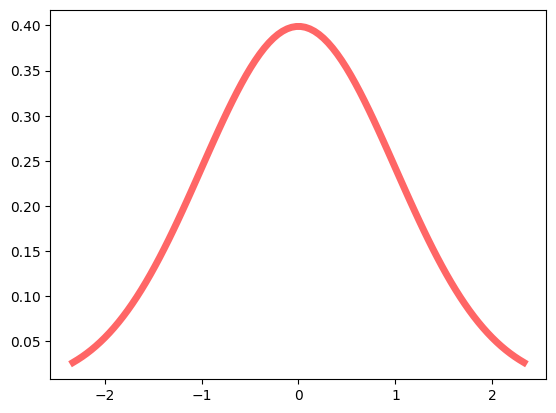

array([ 1.67485886e+00, -1.96347450e+00, -1.48946569e+00,  6.06373268e-01,
        1.25986478e-01,  2.12214330e+00, -1.77814318e+00,  5.12476973e-01,
        3.45420211e-01, -3.42877362e-01,  2.50938876e-01, -5.13073345e-01,
       -8.31221718e-01, -8.22215802e-01,  2.12538676e+00,  4.11541281e-01,
        4.36595965e-01, -1.41334347e+00,  7.17430521e-01, -5.49605560e-01,
        1.32887857e+00, -1.16452437e-01, -7.84177443e-01,  6.48986440e-01,
        2.95931578e-01, -5.11218425e-01,  1.89009180e-01,  1.22617181e-01,
        7.09731033e-01,  1.17959352e+00,  3.09576457e-01, -1.62613097e-01,
        8.14089249e-01, -1.41791753e+00,  3.41125639e+00,  3.46369850e-01,
        7.15123737e-01, -6.51640546e-01, -9.70180608e-01,  1.53800932e-01,
        4.25664811e-01,  1.22597587e+00, -5.07806653e-01, -7.04987907e-02,
       -4.03104074e-01,  1.10590021e+00,  1.39959715e-01, -1.84789287e+00,
        2.54044289e+00, -9.99108001e-01, -2.26808776e+00, -6.69067970e-01,
        1.48303808e+00,  

In [459]:
myClipA = -6
myClipB = 6
mean = 0
deviation = 1

fig, ax = plt.subplots(1,1)

deviationClipA = (myClipA - mean)/ deviation
deviationClipB = (myClipB - mean)/ deviation

x = np.linspace(truncnorm.ppf(0.01, deviationClipA, deviationClipB), truncnorm.ppf(0.99, deviationClipA, deviationClipB), 100)

ax.plot(x, truncnorm.pdf(x, deviationClipA, deviationClipB), 'r-', lw = 5, alpha = 0.6, label='truncnorm pdf')
plt.show()

In [768]:
def VertexMCMC(spinJ, iterationsNumber, batchSize, deviation, burnFactor, verbosity, drawsFolder, mean = 0.):

    dimensions = 2

    gridLength = 2*np.int64(spinJ) + 1


    if(iterationsNumber % batchSize != 0):
        raise ValueError("Number of iterations must be a multiple of batch size.")
    
    
    truncatedCoefficients = discreteNormalDistribution(gridLength, 0, deviation)

    if(verbosity > 1):
        print("Truncated coefficients for j =",spinJ,"are",truncatedCoefficients)

    draw = np.zeros(dimensions + 1, dtype=np.int64)
    gaussianDraw = np.zeros(dimensions , np.int64)

    amplitude = 0.0
  
    while( amplitude == 0 ):
        for i in range(np.size(draw)):
            draw[i] = np.random.randint(gridLength)
        
        positionProbability = grid_rewards_2d(gridLength=gridLength)
        amplitude = positionProbability[tuple(draw[:-1])]
        
    draw[-1] = 1 # Initial multiplicity

    if (verbosity > 1):
        print("Initial draw is", draw[:-1],"with amplitude", amplitude)

    # Proposed draw
    proposedDraw = np.zeros(dimensions , dtype=np.int64)

    acceptanceRatio = 0
    multiplicity = 1    # initial multiplicity counter
    
    RWMonitor = True

    dfAllBatches = pd.DataFrame({"acceptance rate (%)":[], "run time (s)":[]})

    batchCounter = 0

    draws = np.empty( shape=(1,dimensions + 1))

    for n in range(1, iterationsNumber):
        if(verbosity > 1):
            print("Iteration ", n, "---------------------------------------------------------------")

        timeInitial = time.time_ns() # Initial time


        if( n % batchSize ==0 ):
            
            if(verbosity >1):
                print(n,"iterations reached, time to store",batchSize,"draws.")
            draws = np.append(draws, np.array([np.append(draw[:-1] - 1, multiplicity)]), axis=0)

            if(verbosity > 1):
                print("The last draw", draw[:-1],"has been stored with multiplicity", draw[-1])
            
            acceptancePercentage = acceptanceRatio * 100/ batchSize

            print(acceptancePercentage,"of proposed draws have beem accepted in this batch (in master chain).")

            batchCounter += 1

            # Create file and layout.
            if(not os.path.exists(str(drawsFolder)+"/draws_batch_n_"+str(batchCounter)+".csv")):
                os.makedirs(str(drawsFolder), exist_ok=True)   

            print(draws)       
            
            
            dfCurrentBatch = pd.DataFrame(draws, columns=[ "dimension 1",
                    "dimension 2",
                    "multiplicity"]
            )
            
            # Write new batch to csv.
            dfCurrentBatch.to_csv(str(drawsFolder)+"/draws_batch_n_"+str(batchCounter)+".csv", index=False, mode='w', header=True)

            
            timeFinal = time.time_ns()

            acceptanceRatio = 0
            multiplicity = 1

            draws = np.zeros(shape=(1,dimensions + 1 ), dtype=np.int64)

            allBatchesStatistics = np.zeros(shape=(1,2))

            allBatchesStatistics = np.append(allBatchesStatistics, [[acceptancePercentage,  round((timeFinal - timeInitial * 10**(-9) ), ndigits=4)]], axis=0)

            if(n == iterationsNumber):
                # Create file for data of all batches.
                if(not os.path.exists(str(drawsFolder)+"/statistics_batches.csv")):
                    # Add batches' attributes to dataframe.
                    dfAllBatches = pd.DataFrame(draws, columns=[ "acceptance rate (%)", "run time (s)"])
                    # Write them to csv. 
                    dfAllBatches.to_csv(str(drawsFolder)+"/statistics_batches.csv", index=False, mode='w', header=True)


        RWMonitor = True

        #Sampling proposed draw.
        Cx = CxProbability = 1.0

        for i in range(len(gaussianDraw)):

            while(True):
                drawFloatSample = deviation*np.random.randn() + mean
                gaussianDraw[i] = int(round(drawFloatSample))
                proposedDraw[i] = draw[i] + gaussianDraw[i]
            
                if(((1 <= proposedDraw[i]) and (proposedDraw[i] < gridLength))):
                    break
            
            if(gaussianDraw[i] != 0):
                RWMonitor = False
            
            Cx *= truncatedCoefficients[draw[i]]
            CxProbability *= truncatedCoefficients[proposedDraw[i]]

        if(RWMonitor == True):
            acceptanceRatio += 1

            multiplicity += 1

            if(verbosity > 1):
                print("The propposedDraw:", proposedDraw[-1], "turns out to be equal to the current draw:", draw[:-1],"\nso that the multiplicity of the current draw is raised to",multiplicity)
            
        else:
            if(verbosity > 1):
                print("draw is",draw[:-1],"\nproposedDraw is",proposedDraw,"\namplitude is",amplitude)
            
            
            positionProbability = grid_rewards_2d(gridLength=gridLength)            
            proposedAmplitude = positionProbability[tuple(proposedDraw)]


            probability = np.amin([1, (proposedAmplitude**2)/ (amplitude**2) * (Cx / CxProbability)])

            if(np.isnan(probability)):
                raise ValueError("Got NaN while computing densitites ration: proposedDraw", proposedDraw, "amplitude= ", amplitude)

            randomNumber = np.random.rand()

            if(randomNumber < probability):
                if(verbosity > 1):
                    print("prposedDraw", proposedDraw, "was accepted, since p=", probability, "and randomNumber", randomNumber)

                if(n > burnFactor):
                    
                    draws = np.append(draws, np.array([np.append(draw[:-1] - 1, multiplicity)]), axis=0)

                    if(verbosity > 1):
                        print("The old draw", draw[:-1], "has been stores with multiplicity", draw[-1])
                    
                multiplicity = 1

                for i in range(len(proposedDraw)):
                    draw[i] = proposedDraw[i]
                
                amplitude = proposedAmplitude
                acceptanceRatio += 1

                if(verbosity > 1):
                    print("Now the new draw is", draw[:-1],"\nthe new amplitude is", amplitude)
            
            else:
                multiplicity += 1
                if(verbosity > 1):
                    print("proposedDraw", proposedDraw, "was rejected, since probability=", probability, "and randomNumber=",randomNumber)
                    print("The current draw", draw[:-1], "remains the same and its multiplicity is:", multiplicity)
                    print("Amplitude", amplitude, "remains the same")
            



    


In [769]:
iterationsNumber = 10**3
batchSize = 100
burnFactor = 0
deviation = 0.8
spinJ = 4

drawsFolderBase = "../data/2DComparison/iterations_"+str(iterationsNumber)+"_batch_size_"+str(batchSize)+"_burnin_"+str(burnFactor)+"_sigma_"+str(deviation)
verbosity = 2

drawsFolder = str(drawsFolderBase)+"/j_"+str(spinJ)+"/draws/"
os.makedirs(drawsFolder, exist_ok=True)

VertexMCMC(spinJ, iterationsNumber, batchSize, deviation, burnFactor, verbosity, drawsFolder, mean = 0.)

Truncated coefficients for j = 4 are [6.67328 6.96985 7.00034 5.99381 7.99556 6.99757 4.99489 3.03469 1.32692]
Initial draw is [3 2] with amplitude 0.1
Iteration  1 ---------------------------------------------------------------
0 iteration out of: 21 iteration out of: 2draw is [3 2] 
proposedDraw is [4 2] 
amplitude is 0.1
prposedDraw [4 2] was accepted, since p= 0.7496423014773199 and randomNumber 0.25905249544475106
Draws= (1, 3)
Draw = (3,)
The old draw [3 2] has been stores with multiplicity 1
Now the new draw is [4 2] 
the new amplitude is 0.1
Iteration  2 ---------------------------------------------------------------
0 iteration out of: 21 iteration out of: 2The propposedDraw: 2 turns out to be equal to the current draw: [4 2] 
so that the multiplicity of the current draw is raised to 2
Iteration  3 ---------------------------------------------------------------
0 iteration out of: 21 iteration out of: 2The propposedDraw: 2 turns out to be equal to the current draw: [4 2] 
so t

In [756]:
x = np.array([[1,2,3,4]])
y = np.array([[4,5,6,7]])
z = np.array([8,9,10,11])

#print(np.append(x[:-1],8))

#print(np.append(x,y, axis=0))

#print(np.append(np.append(x,y, axis=0), z, axis=0))

print(z[:-1])

print(np.array([np.append(z[:-1],1)]))

z = np.array([np.append(z[:-1],1)])

print(np.append(x,z, axis=0))

#x = np.append(np.append(x,y, axis=0), [np.append(z,1)], axis=0)

#print(x)

[ 8  9 10]
[[ 8  9 10  1]]
[[ 1  2  3  4]
 [ 8  9 10  1]]
